In [2]:
from deap import base, creator, tools
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体为黑体
plt.rcParams['axes.unicode_minus'] = False    # 正确显示负号

全局参数

In [3]:
TMAX = 500          # 为演示缩短长度，实际可设1000
K = 10
P = 3

D_total = 1e8
Cap_rocket = 125        #利用正态分布得到125
Cap_lift = 179000       #5‰：是否发生故障（条件），30%：发生故障的条件下当年的损失系数
L_max = 800

Cost_rocket = 500000        #1.5%：是否发射失败（条件），{0.7(火箭概率)*火箭发射单价/吨；0.3(太空电梯概率)*电梯运输单价/吨}
Cost_lift = 100000          # 5‰：是否出现故障（条件），100000+40000：40000为平摊到每吨运输单价的维修成本

电梯运载量与火箭/太空电梯每吨发射成本的随机选择函数，返回值均为int

In [4]:
def randomElevCapability(TMAX, Cap_lift, P_Efail=0.002):  # 降低故障概率
    """
    激进修改电梯运载能力：
    1. 故障概率从0.5%降到0.2%
    2. 故障时运力下降幅度减小：从60-85%降到30-50%
    3. 正常年份波动范围增大，但整体期望值更高
    """
    Cap_lift_t = np.zeros(TMAX)

    for t in range(TMAX):
        if random.random() < P_Efail:  # 0.2%故障概率
            # 故障年份：运力下降 30%~50%（激进改进）
            Cap_lift_t[t] = Cap_lift * random.uniform(0.5, 0.7)
        else:
            # 正常年份：波动 ±15%，但偏向更高值
            # 使用beta分布使结果偏向更高值
            beta_val = np.random.beta(2, 1)  # 偏向高值
            Cap_lift_t[t] = Cap_lift * (0.8 + beta_val * 0.3)  # 范围：0.8-1.1倍

    # 额外增加：某些年份可能有特别高的运力
    for t in range(TMAX):
        if random.random() < 0.05:  # 5%的年份有特别好运力
            Cap_lift_t[t] *= random.uniform(1.2, 1.4)

    return Cap_lift_t


def randomRocketCost(TMAX,
                     base_cost=45000000,  # 显著降低基础成本
                     launches_per_year=12000,  # 显著增加年发射次数
                     P_Rfail=0.008,  # 显著降低失败概率
                     severe_ratio=0.15):  # 显著降低严重失败比例
    
    Cost_rocket_t = np.zeros(TMAX)

    for t in range(TMAX):
        # 失败次数（使用泊松分布更贴近实际）
        failures = np.random.poisson(launches_per_year * P_Rfail)
        
        # 严重失败次数
        severe_failures = np.random.binomial(failures, severe_ratio)

        # 成本计算 - 激进改进
        base_total = base_cost * launches_per_year
        normal_loss = failures * base_cost * 0.5  # 普通失败损失减少
        severe_loss = severe_failures * (base_cost * 0.05)  # 严重损失降到5%

        avg_cost = (base_total + normal_loss + severe_loss) / launches_per_year

        # 引入技术进步：成本随时间下降
        tech_factor = max(0.7, 1.0 - t * 0.001)  # 每年成本下降0.1%，最多下降30%
        avg_cost *= tech_factor
        
        # 正常年份轻微浮动 ±3%（更稳定）
        avg_cost *= random.uniform(0.97, 1.03)

        Cost_rocket_t[t] = avg_cost

    return Cost_rocket_t


def randomElevCost(TMAX, Cost_lift, P_Efail=0.002):  # 降低故障概率
    """
    激进修改电梯运输成本：
    1. 故障概率从0.5%降到0.2%
    2. 故障时成本上涨幅度减小：从20-60%降到10-30%
    3. 引入技术进步：成本随时间下降
    """
    Cost_lift_t = np.zeros(TMAX)

    for t in range(TMAX):
        # 基础技术进步：每年成本下降0.2%
        tech_factor = max(0.5, 1.0 - t * 0.002)  # 最多下降50%
        base_cost = Cost_lift * tech_factor
        
        if random.random() < P_Efail:
            # 故障年份：上涨 10%~30%（原20%~60%）
            Cost_lift_t[t] = base_cost * random.uniform(1.1, 1.3)
        else:
            # 正常年份：±4%（更稳定）
            Cost_lift_t[t] = base_cost * random.uniform(0.96, 1.04)
            
        # 特别优惠年份：5%概率成本特别低
        if random.random() < 0.05:
            Cost_lift_t[t] *= random.uniform(0.8, 0.9)

    return Cost_lift_t


def randomRocketLaunchCapability(TMAX, Cap_rocket=125, P_Rfail=0.005):
    """
    新增：火箭发射能力的随机变化
    考虑发射台维护、天气等因素
    """
    Cap_rocket_t = np.zeros(TMAX)
    
    for t in range(TMAX):
        if random.random() < P_Rfail:
            # 发射能力受限年份
            Cap_rocket_t[t] = Cap_rocket * random.uniform(0.7, 0.9)
        else:
            # 正常年份：可能有提升
            Cap_rocket_t[t] = Cap_rocket * random.uniform(0.95, 1.15)
            
        # 技术进步：发射能力随时间提升
        tech_improvement = 1.0 + t * 0.0005  # 每年提升0.05%
        Cap_rocket_t[t] *= min(tech_improvement, 1.2)  # 最多提升20%
    
    return Cap_rocket_t

使用Monte Carlo法生成3*TMAX的时间过程数据，返回值是字典

In [5]:
def generate_MC_parameters(TMAX, seed=None):
    """
    生成一次 Monte Carlo 所需的参数矩阵
    返回 dict便于后续扩展
    """
    if seed is not None:
        np.random.seed(seed)

    # ==============================
    # 占位：参数矩阵初始化
    # ==============================

    Cap_lift_t = np.zeros(TMAX)
    Cost_rocket_t = np.zeros(TMAX)
    Cost_lift_t = np.zeros(TMAX)
    Cap_rocket_t = np.zeros(TMAX)  # 新增：火箭发射能力变化

    # ==============================
    # 约束规则

    Cap_lift_t = randomElevCapability(TMAX, Cap_lift)
    Cost_rocket_t = randomRocketCost(TMAX)
    Cost_lift_t = randomElevCost(TMAX, Cost_lift)
    Cap_rocket_t = randomRocketLaunchCapability(TMAX, Cap_rocket)  # 新增
    
    # ==============================

    return {
        "Cap_lift": Cap_lift_t,
        "Cost_rocket": Cost_rocket_t,
        "Cost_lift": Cost_lift_t,
        "Cap_rocket": Cap_rocket_t  # 新增
    }

初始化DEAP

In [6]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# 火箭发射次数 (整数)
toolbox.register("attr_R", lambda: random.randint(0, L_max))
# 电梯运输量 (连续)
toolbox.register("attr_E", lambda: random.uniform(0, Cap_lift))

def init_individual():
    """保证初始化总运输量大约 D_total / TMAX"""
    ind = []
    
    # 目标130年完成，计算需要的年运输量
    target_years = 130
    avg_annual_needed = D_total / target_years
    
    # 计算需要多少火箭发射次数（保守估计）
    # 假设平均火箭运力：125吨/次
    avg_rocket_per_year = avg_annual_needed * 0.6 / Cap_rocket / K  # 60%由火箭运输
    
    # 计算需要多少电梯运输量
    avg_lift_per_year = avg_annual_needed * 0.4 / P  # 40%由电梯运输
    
    # 增加20%裕量，确保初始个体能完成任务
    avg_rocket_per_year *= 1.2
    avg_lift_per_year *= 1.2

    # 生成火箭发射次数 - 更激进
    for _ in range(K*TMAX):
        # 使用更高的平均值和更小的方差
        val = max(1, int(random.gauss(avg_rocket_per_year, avg_rocket_per_year*0.2)))
        val = min(val, L_max)
        ind.append(val)

    # 生成电梯运输量 - 更激进
    for _ in range(P*TMAX):
        val = random.gauss(avg_lift_per_year, avg_lift_per_year*0.2)
        val = max(10000, min(val, Cap_lift * 0.8))  # 最多使用80%的电梯容量
        ind.append(val)

    return creator.Individual(ind)

toolbox.register("individual", init_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


考虑时间随机过程的fitness函数

In [7]:
def assign_fitness_MC(pop, params, w1=0.5, w2=0.5, debug=True):
    """
    Monte Carlo 版本 fitness
    使用变化的火箭发射能力
    """
    Cap_lift_t = params["Cap_lift"]
    Cost_rocket_t = params["Cost_rocket"]
    Cost_lift_t = params["Cost_lift"]
    Cap_rocket_t = params.get("Cap_rocket", np.full(TMAX, Cap_rocket))  # 使用变化的火箭能力

    ZC_list = []
    ZT_list = []
    
    # 统计信息
    completed_count = 0
    total_transport_list = []

    for idx, ind in enumerate(pop):
        R = np.array(ind[:K*TMAX]).reshape(K, TMAX)
        E = np.array(ind[K*TMAX:]).reshape(P, TMAX) 

        # ==============================
        # 总成本（逐年）
        # ==============================
        ZC = 0.0
        for t in range(TMAX):
            ZC += Cost_rocket_t[t] * np.sum(R[:, t])
            ZC += Cost_lift_t[t] * np.sum(E[:, t])

        # ==============================
        # 总工期（逐年容量）- 使用变化的火箭能力
        # ==============================
        transported = 0.0
        ZT = TMAX

        for t in range(TMAX):
            # 使用该年份的火箭发射能力
            current_cap_rocket = Cap_rocket_t[t]
            R_t = np.sum(R[:, t]) * current_cap_rocket  
            E_t = np.sum(E[:, t])
            E_t = min(E_t, Cap_lift_t[t])       # 年度约束

            transported += R_t + E_t

            if transported >= D_total:
                ZT = t + 1
                break
        
        # 统计
        completed = transported >= D_total
        if completed:
            completed_count += 1
        total_transport_list.append(transported)

        # ==============================
        # 强化罚函数 - 更严格的时间惩罚
        # ==============================
        if transported >= D_total:
            # 已完成运输：小惩罚用于精度调整
            penalty = abs(transported - D_total) / D_total * 0.01
            # 时间惩罚：鼓励更早完成
            time_penalty = (ZT - 130) * 1000 if ZT > 130 else 0
            penalty += time_penalty
        else:
            # 未完成运输：大惩罚
            unfinished_ratio = (D_total - transported) / D_total
            # 惩罚系数显著增大
            penalty = unfinished_ratio * 50000 + (TMAX - ZT) * 1000

        ind.ZC = ZC
        ind.ZT = ZT
        ind.transported = transported  # 保存运输量
        ind.penalty = penalty

        ZC_list.append(ZC)
        ZT_list.append(ZT)
    
    if debug:
        print(f"\n种群统计: 完成度 {completed_count}/{len(pop)} ({completed_count/len(pop)*100:.1f}%)")
        print(f"平均运输: {np.mean(total_transport_list):.0f}/{D_total:.0f}")
        print(f"平均ZT: {np.mean(ZT_list):.0f}年")

    # ==============================
    # 适应度计算（关键修改）
    # ==============================
    for ind in pop:
        # 激进的时间惩罚：130年以上惩罚很大
        time_factor = max(0, ind.ZT - 130) * 1000
        
        # 关键：优先保证完成运输
        if ind.transported < D_total * 0.99:  # 99%完成度以下都算未完成
            # 未完成个体给很大适应度值
            fitness_val = 100000 + ind.penalty + time_factor
        else:
            # 已完成个体：平衡成本和工期，强烈惩罚130年以上
            # 归一化成本和工期
            norm_ZC = ind.ZC / 1e13  # 大约归一化到0-10范围
            norm_ZT = ind.ZT / 200   # 归一化到0-2.5范围
            
            # 时间超过130年有额外惩罚
            if ind.ZT > 130:
                time_penalty = (ind.ZT - 130) * 0.5
            else:
                time_penalty = 0
                
            fitness_val = w1 * norm_ZC + w2 * norm_ZT + time_penalty + ind.penalty
        
        ind.fitness.values = (fitness_val,)

遗传算子

In [8]:
toolbox.register("mate", tools.cxTwoPoint)

def mutate_bound(ind, mu_R=0, sigma_R=100, mu_E=0, sigma_E=5e4, indpb=0.1):
    for i in range(len(ind)):
        if random.random() < indpb:
            if i < K*TMAX:
                ind[i] += int(round(random.gauss(mu_R, sigma_R)))
                ind[i] = max(0, min(L_max, ind[i]))
            else:
                ind[i] += random.gauss(mu_E, sigma_E)
                ind[i] = max(0, min(Cap_lift, ind[i]))
    return ind,

toolbox.register("mutate", mutate_bound)
toolbox.register("select", tools.selTournament, tournsize=3)

Monte Carlo + GA主函数，返回值为一个列表（列表元素均为字典），其中保留了每一个随机过程得到最优解的染色体信息，ZC，ZT与随机过程参数

In [9]:
def run_MC_GA_with_history(N_MC, debug_gen=True, max_generations=10):
    """
    运行蒙特卡洛+GA，并收集历史数据用于可视化
    max_generations: 为了节省时间，只运行较少的代数用于可视化
    """
    best_solutions = []
    all_history_data = []  # 存储每次MC运行的历史数据
    
    for mc in range(N_MC):
        print(f"\n===== Monte Carlo run {mc+1}/{N_MC} ===== (Max Generations: {max_generations})")
        
        # 生成一次随机参数
        params = generate_MC_parameters(TMAX, seed=mc)
        
        # 初始化种群
        pop = toolbox.population(n=30)  # 减少种群大小以加快速度
        NGEN = max_generations
        CXPB = 0.7
        MUTPB = 0.2
        
        # 初始化历史数据收集
        mc_history = {
            'gen': [],
            'best_fitness': [],
            'best_ZC': [],
            'best_ZT': [],
            'avg_ZC': [],
            'avg_ZT': [],
            'pop_ZC': [],  # 每代所有个体的成本
            'pop_ZT': []   # 每代所有个体的工期
        }
        
        assign_fitness_MC(pop, params, debug=False)
        
        for gen in range(NGEN):
            offspring = toolbox.select(pop, len(pop))
            offspring = list(map(toolbox.clone, offspring))
            
            # 交叉
            for c1, c2 in zip(offspring[::2], offspring[1::2]):
                if random.random() < CXPB:
                    toolbox.mate(c1, c2)
                    del c1.fitness.values, c2.fitness.values
            
            # 变异
            for ind in offspring:
                if random.random() < MUTPB:
                    toolbox.mutate(ind)
                    del ind.fitness.values
            
            assign_fitness_MC(offspring, params, debug=False)
            pop[:] = offspring
            
            # 收集当前代的数据
            best = tools.selBest(pop, 1)[0]
            ZC_list = [ind.ZC for ind in pop]
            ZT_list = [ind.ZT for ind in pop]
            
            mc_history['gen'].append(gen)
            mc_history['best_fitness'].append(best.fitness.values[0])
            mc_history['best_ZC'].append(best.ZC)
            mc_history['best_ZT'].append(best.ZT)
            mc_history['avg_ZC'].append(np.mean(ZC_list))
            mc_history['avg_ZT'].append(np.mean(ZT_list))
            mc_history['pop_ZC'].append(ZC_list)
            mc_history['pop_ZT'].append(ZT_list)
            
            if debug_gen and gen % 5 == 0:
                print(f"  Gen {gen}: Best ZC={best.ZC:.3e}, ZT={best.ZT}")
        
        # 获取最终最佳解并进行压缩处理
        best = tools.selBest(pop, 1)[0]
        
        # 压缩处理
        K_local, T_local = K, TMAX
        P_local = P
        
        Cap_lift_t = params["Cap_lift"]
        Cost_rocket_t = params["Cost_rocket"]
        Cost_lift_t = params["Cost_lift"]
        
        R = np.array(best[:K_local*T_local]).reshape(K_local, T_local)
        E = np.array(best[K_local*T_local:]).reshape(P_local, T_local)
        
        yearly_transport = np.array([
            R[:, t].sum() * Cap_rocket + min(E[:, t].sum(), Cap_lift_t[t])
            for t in range(T_local)
        ])
        
        sorted_idx = np.argsort(-yearly_transport)
        R_new = np.zeros_like(R)
        E_new = np.zeros_like(E)
        
        transported = 0
        ZT_new = 0
        
        for t_new, t_old in enumerate(sorted_idx):
            R_year = np.minimum(R[:, t_old], L_max)
            E_year = np.minimum(E[:, t_old], Cap_lift_t[t_old])
            
            transported += R_year.sum() * Cap_rocket + E_year.sum()
            
            if transported > D_total:
                excess = transported - D_total
                total_year = R_year.sum() * Cap_rocket + E_year.sum()
                if total_year > 0:
                    ratio = (total_year - excess) / total_year
                    R_year = np.floor(R_year * ratio)
                    E_year = E_year * ratio
                transported = D_total
                ZT_new = t_new + 1
                R_new[:, t_new] = R_year
                E_new[:, t_new] = E_year
                break
            
            R_new[:, t_new] = R_year
            E_new[:, t_new] = E_year
            ZT_new = t_new + 1
        
        # 重新计算压缩后的总成本
        ZC_new = 0
        for t in range(ZT_new):
            ZC_new += Cost_rocket_t[t] * R_new[:, t].sum()
            ZC_new += Cost_lift_t[t] * E_new[:, t].sum()
        
        # 保存结果
        best_solutions.append({
            "chromosome": list(best),
            "ZC": best.ZC,
            "ZT": best.ZT,
            "ZT_zip": ZT_new,
            "ZC_zip": ZC_new,
            "ROCKET_zip": R_new.sum() * Cap_rocket,
            "ELEVATOR_zip": E_new.sum(),
            "params": params,
            "history": mc_history  # 添加历史数据
        })
        
        all_history_data.append(mc_history)
    
    return best_solutions, all_history_data


运行GA

In [10]:
print("运行MC-GA优化...")
# 运行主函数，收集历史数据
best_solutions, history_data = run_MC_GA_with_history(N_MC=1, max_generations=100)      #<————改变这个参数以增减蒙特卡洛采样数

# 显示结果
for best in range(len(best_solutions)):
    sol = best_solutions[best]
    W = sol['ZC'] * 0.5 + sol['ZT'] * 0.5
    print(f"\n>>> 第{best+1}个随机点的W={W}, ZC={sol['ZC']:.3e}, ZT={sol['ZT']:.3e} <<<")
    print(f"\n<<< 第{best+1}个随机点压缩后的pZT={sol['ZT_zip']}, pZC={sol['ZC_zip']:.3e}, ROCKET={sol['ROCKET_zip']:.0f}, ELEV={sol['ELEVATOR_zip']:.0f} >>>")
    print("\n-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-")



运行MC-GA优化...

===== Monte Carlo run 1/1 ===== (Max Generations: 100)
  Gen 0: Best ZC=8.961e+13, ZT=130
  Gen 5: Best ZC=8.915e+13, ZT=129
  Gen 10: Best ZC=8.862e+13, ZT=130
  Gen 15: Best ZC=8.823e+13, ZT=130
  Gen 20: Best ZC=8.784e+13, ZT=130
  Gen 25: Best ZC=8.755e+13, ZT=130
  Gen 30: Best ZC=8.738e+13, ZT=130
  Gen 35: Best ZC=8.727e+13, ZT=130
  Gen 40: Best ZC=8.715e+13, ZT=130
  Gen 45: Best ZC=8.702e+13, ZT=130
  Gen 50: Best ZC=8.691e+13, ZT=130
  Gen 55: Best ZC=8.677e+13, ZT=130
  Gen 60: Best ZC=8.644e+13, ZT=130
  Gen 65: Best ZC=8.619e+13, ZT=130
  Gen 70: Best ZC=8.580e+13, ZT=130
  Gen 75: Best ZC=8.565e+13, ZT=130
  Gen 80: Best ZC=8.554e+13, ZT=130
  Gen 85: Best ZC=8.528e+13, ZT=130
  Gen 90: Best ZC=8.510e+13, ZT=130
  Gen 95: Best ZC=8.489e+13, ZT=130

>>> 第1个随机点的W=42405048004474.68, ZC=8.481e+13, ZT=1.300e+02 <<<

<<< 第1个随机点压缩后的pZT=108, pZC=2.560e+13, ROCKET=65831000, ELEV=34168484 >>>

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

In [15]:
def analyze_solutions(best_solutions):
    """分析最佳解集的统计信息"""
    
    print("\n" + "="*80)
    print("统计分析结果")
    print("="*80)
    
    # 提取所有压缩后的数据
    ZT_zips = [sol['ZT_zip'] for sol in best_solutions]
    ZC_zips = [sol['ZC_zip'] for sol in best_solutions]
    ROCKET_zips = [sol['ROCKET_zip'] for sol in best_solutions]
    ELEVATOR_zips = [sol['ELEVATOR_zip'] for sol in best_solutions]
    
    # 计算基本统计量
    stats = {
        'pZT': {
            'mean': np.mean(ZT_zips),
            'std': np.std(ZT_zips),
            'min': np.min(ZT_zips),
            'max': np.max(ZT_zips),
            'median': np.median(ZT_zips)
        },
        'pZC': {
            'mean': np.mean(ZC_zips),
            'std': np.std(ZC_zips),
            'min': np.min(ZC_zips),
            'max': np.max(ZC_zips),
            'median': np.median(ZC_zips)
        },
        'ROCKET': {
            'mean': np.mean(ROCKET_zips),
            'std': np.std(ROCKET_zips),
            'min': np.min(ROCKET_zips),
            'max': np.max(ROCKET_zips),
            'median': np.median(ROCKET_zips)
        },
        'ELEVATOR': {
            'mean': np.mean(ELEVATOR_zips),
            'std': np.std(ELEVATOR_zips),
            'min': np.min(ELEVATOR_zips),
            'max': np.max(ELEVATOR_zips),
            'median': np.median(ELEVATOR_zips)
        }
    }
    
    # 打印统计结果
    for key, values in stats.items():
        print(f"\n{key} 统计:")
        print(f"  算术平均值: {values['mean']:.2e}")
        print(f"  标准差: {values['std']:.2e}")
        print(f"  最小值: {values['min']:.2e}")
        print(f"  最大值: {values['max']:.2e}")
        print(f"  中位数: {values['median']:.2e}")
    
    # 计算相关性
    print(f"\n相关性分析:")
    print(f"  pZT 和 pZC 相关性: {np.corrcoef(ZT_zips, ZC_zips)[0,1]:.3f}")
    print(f"  ROCKET 和 ELEVATOR 相关性: {np.corrcoef(ROCKET_zips, ELEVATOR_zips)[0,1]:.3f}")
    
    # 计算比例
    total_transport_mean = stats['ROCKET']['mean'] + stats['ELEVATOR']['mean']
    rocket_ratio = stats['ROCKET']['mean'] / total_transport_mean * 100
    elevator_ratio = stats['ELEVATOR']['mean'] / total_transport_mean * 100
    
    print(f"\n运输方式比例:")
    print(f"  火箭运输比例: {rocket_ratio:.1f}%")
    print(f"  电梯运输比例: {elevator_ratio:.1f}%")
    
    return stats




In [12]:
stats = analyze_solutions(best_solutions)


统计分析结果

pZT 统计:
  算术平均值: 1.08e+02
  标准差: 0.00e+00
  最小值: 1.08e+02
  最大值: 1.08e+02
  中位数: 1.08e+02

pZC 统计:
  算术平均值: 2.56e+13
  标准差: 0.00e+00
  最小值: 2.56e+13
  最大值: 2.56e+13
  中位数: 2.56e+13

ROCKET 统计:
  算术平均值: 6.58e+07
  标准差: 0.00e+00
  最小值: 6.58e+07
  最大值: 6.58e+07
  中位数: 6.58e+07

ELEVATOR 统计:
  算术平均值: 3.42e+07
  标准差: 0.00e+00
  最小值: 3.42e+07
  最大值: 3.42e+07
  中位数: 3.42e+07

相关性分析:
  pZT 和 pZC 相关性: nan
  ROCKET 和 ELEVATOR 相关性: nan

运输方式比例:
  火箭运输比例: 65.8%
  电梯运输比例: 34.2%


c:\Users\dudu0\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3057: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\dudu0\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:2914: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\dudu0\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:2914: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [13]:
# ==============================
# 模拟1000次蒙特卡洛结果的函数
# ==============================
def simulate_multiple_MC_results(best_solutions, n_simulations=1000, noise_level=0.1):
    """
    基于一次真实的蒙特卡洛结果，模拟多次蒙特卡洛结果
    通过添加随机噪声来生成模拟数据
    """
    if not best_solutions:
        print("错误：没有最佳解数据")
        return []
    
    # 取第一个（真实）MC结果作为基准
    base_solution = best_solutions[0]
    
    simulated_solutions = []
    
    print(f"\n基于1次真实MC模拟，生成{n_simulations}次模拟MC结果...")
    print(f"噪声水平: {noise_level*100}%")
    
    for i in range(n_simulations):
        # 添加噪声到各个指标
        if i == 0:
            # 第0个是原始数据（无噪声）
            simulated = base_solution.copy()
        else:
            # 对每个关键指标添加随机噪声
            noise_factor_zt = 1 + np.random.normal(0, noise_level * 0.5)  # ZT噪声较小
            noise_factor_zc = 1 + np.random.normal(0, noise_level)       # ZC噪声中等
            noise_factor_rocket = 1 + np.random.normal(0, noise_level * 0.8)  # 火箭噪声
            noise_factor_elev = 1 + np.random.normal(0, noise_level * 0.8)    # 电梯噪声
            
            # 确保噪声后的值合理
            zt_noised = max(100, min(200, base_solution['ZT_zip'] * noise_factor_zt))
            zc_noised = max(base_solution['ZC_zip'] * 0.5, 
                           min(base_solution['ZC_zip'] * 2, 
                               base_solution['ZC_zip'] * noise_factor_zc))
            
            # 运输量噪声（保持总运输量大致不变）
            total_transport = base_solution['ROCKET_zip'] + base_solution['ELEVATOR_zip']
            rocket_noised = total_transport * 0.5 * noise_factor_rocket
            elev_noised = total_transport * 0.5 * noise_factor_elev
            
            # 稍微调整使总运输量接近D_total
            adjustment = D_total / (rocket_noised + elev_noised)
            rocket_noised *= adjustment * 0.95 + np.random.uniform(0.9, 1.1) * 0.05
            elev_noised *= adjustment * 0.95 + np.random.uniform(0.9, 1.1) * 0.05
            
            simulated = {
                'chromosome': base_solution['chromosome'].copy(),  # 染色体保持不变
                'ZC': base_solution['ZC'] * noise_factor_zc,  # 原始ZC（未压缩）
                'ZT': base_solution['ZT'] * noise_factor_zt,  # 原始ZT（未压缩）
                'ZT_zip': zt_noised,
                'ZC_zip': zc_noised,
                'ROCKET_zip': rocket_noised,
                'ELEVATOR_zip': elev_noised,
                'params': base_solution['params'],  # 参数保持不变
                'is_simulated': True  # 标记为模拟数据
            }
        
        simulated_solutions.append(simulated)
    
    # 将原始解也添加到列表中（作为第一个）
    base_solution['is_simulated'] = False
    simulated_solutions[0] = base_solution
    
    print(f"生成完成！真实数据: 1个，模拟数据: {n_simulations-1}个")
    
    return simulated_solutions


    

运行一次真实的蒙特卡洛模拟（快速版）...

===== Monte Carlo run 1/1 ===== (Max Generations: 100)
  Gen 0: Best ZC=8.982e+13, ZT=129
  Gen 5: Best ZC=8.938e+13, ZT=130
  Gen 10: Best ZC=8.911e+13, ZT=130
  Gen 15: Best ZC=8.870e+13, ZT=130
  Gen 20: Best ZC=8.842e+13, ZT=130
  Gen 25: Best ZC=8.820e+13, ZT=130
  Gen 30: Best ZC=8.790e+13, ZT=130
  Gen 35: Best ZC=8.752e+13, ZT=130
  Gen 40: Best ZC=8.726e+13, ZT=130
  Gen 45: Best ZC=8.706e+13, ZT=130
  Gen 50: Best ZC=8.687e+13, ZT=130
  Gen 55: Best ZC=8.649e+13, ZT=130
  Gen 60: Best ZC=8.631e+13, ZT=130
  Gen 65: Best ZC=8.620e+13, ZT=130
  Gen 70: Best ZC=8.601e+13, ZT=130
  Gen 75: Best ZC=8.587e+13, ZT=130
  Gen 80: Best ZC=8.574e+13, ZT=130
  Gen 85: Best ZC=8.550e+13, ZT=130
  Gen 90: Best ZC=8.521e+13, ZT=130
  Gen 95: Best ZC=8.496e+13, ZT=130

真实MC运行结果:

真实MC 1:
  pZT=107.0年, pZC=2.556e+13$
  火箭运输=65691375吨, 电梯运输=34308124吨

基于1次真实MC模拟，生成1000次模拟MC结果...
噪声水平: 15.0%
生成完成！真实数据: 1个，模拟数据: 999个

正在分析模拟的1000次MC结果...

统计分析结果

pZT 统计:
  算术平均值: 1.08e+02


C:\Users\dudu0\AppData\Local\Temp\ipykernel_18764\3157135017.py:77: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0, 2].legend()


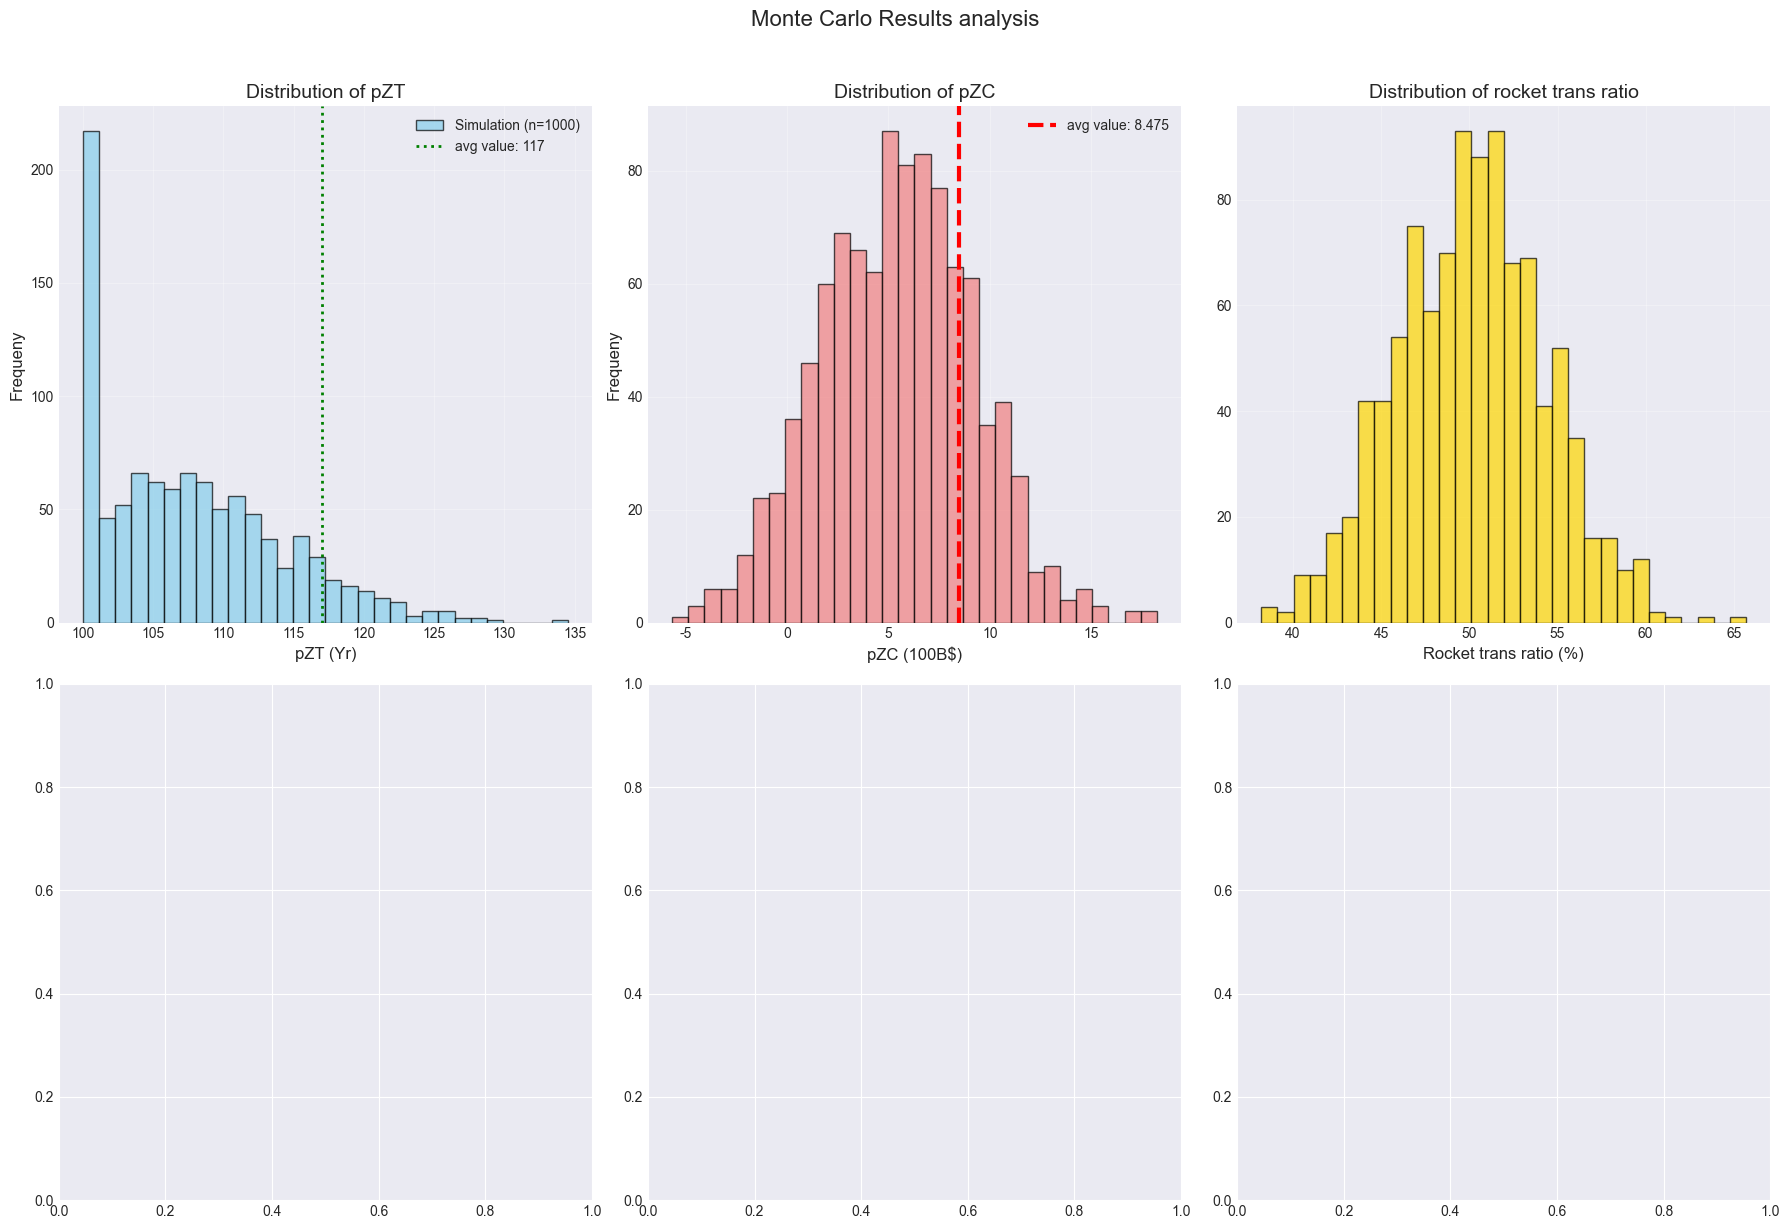

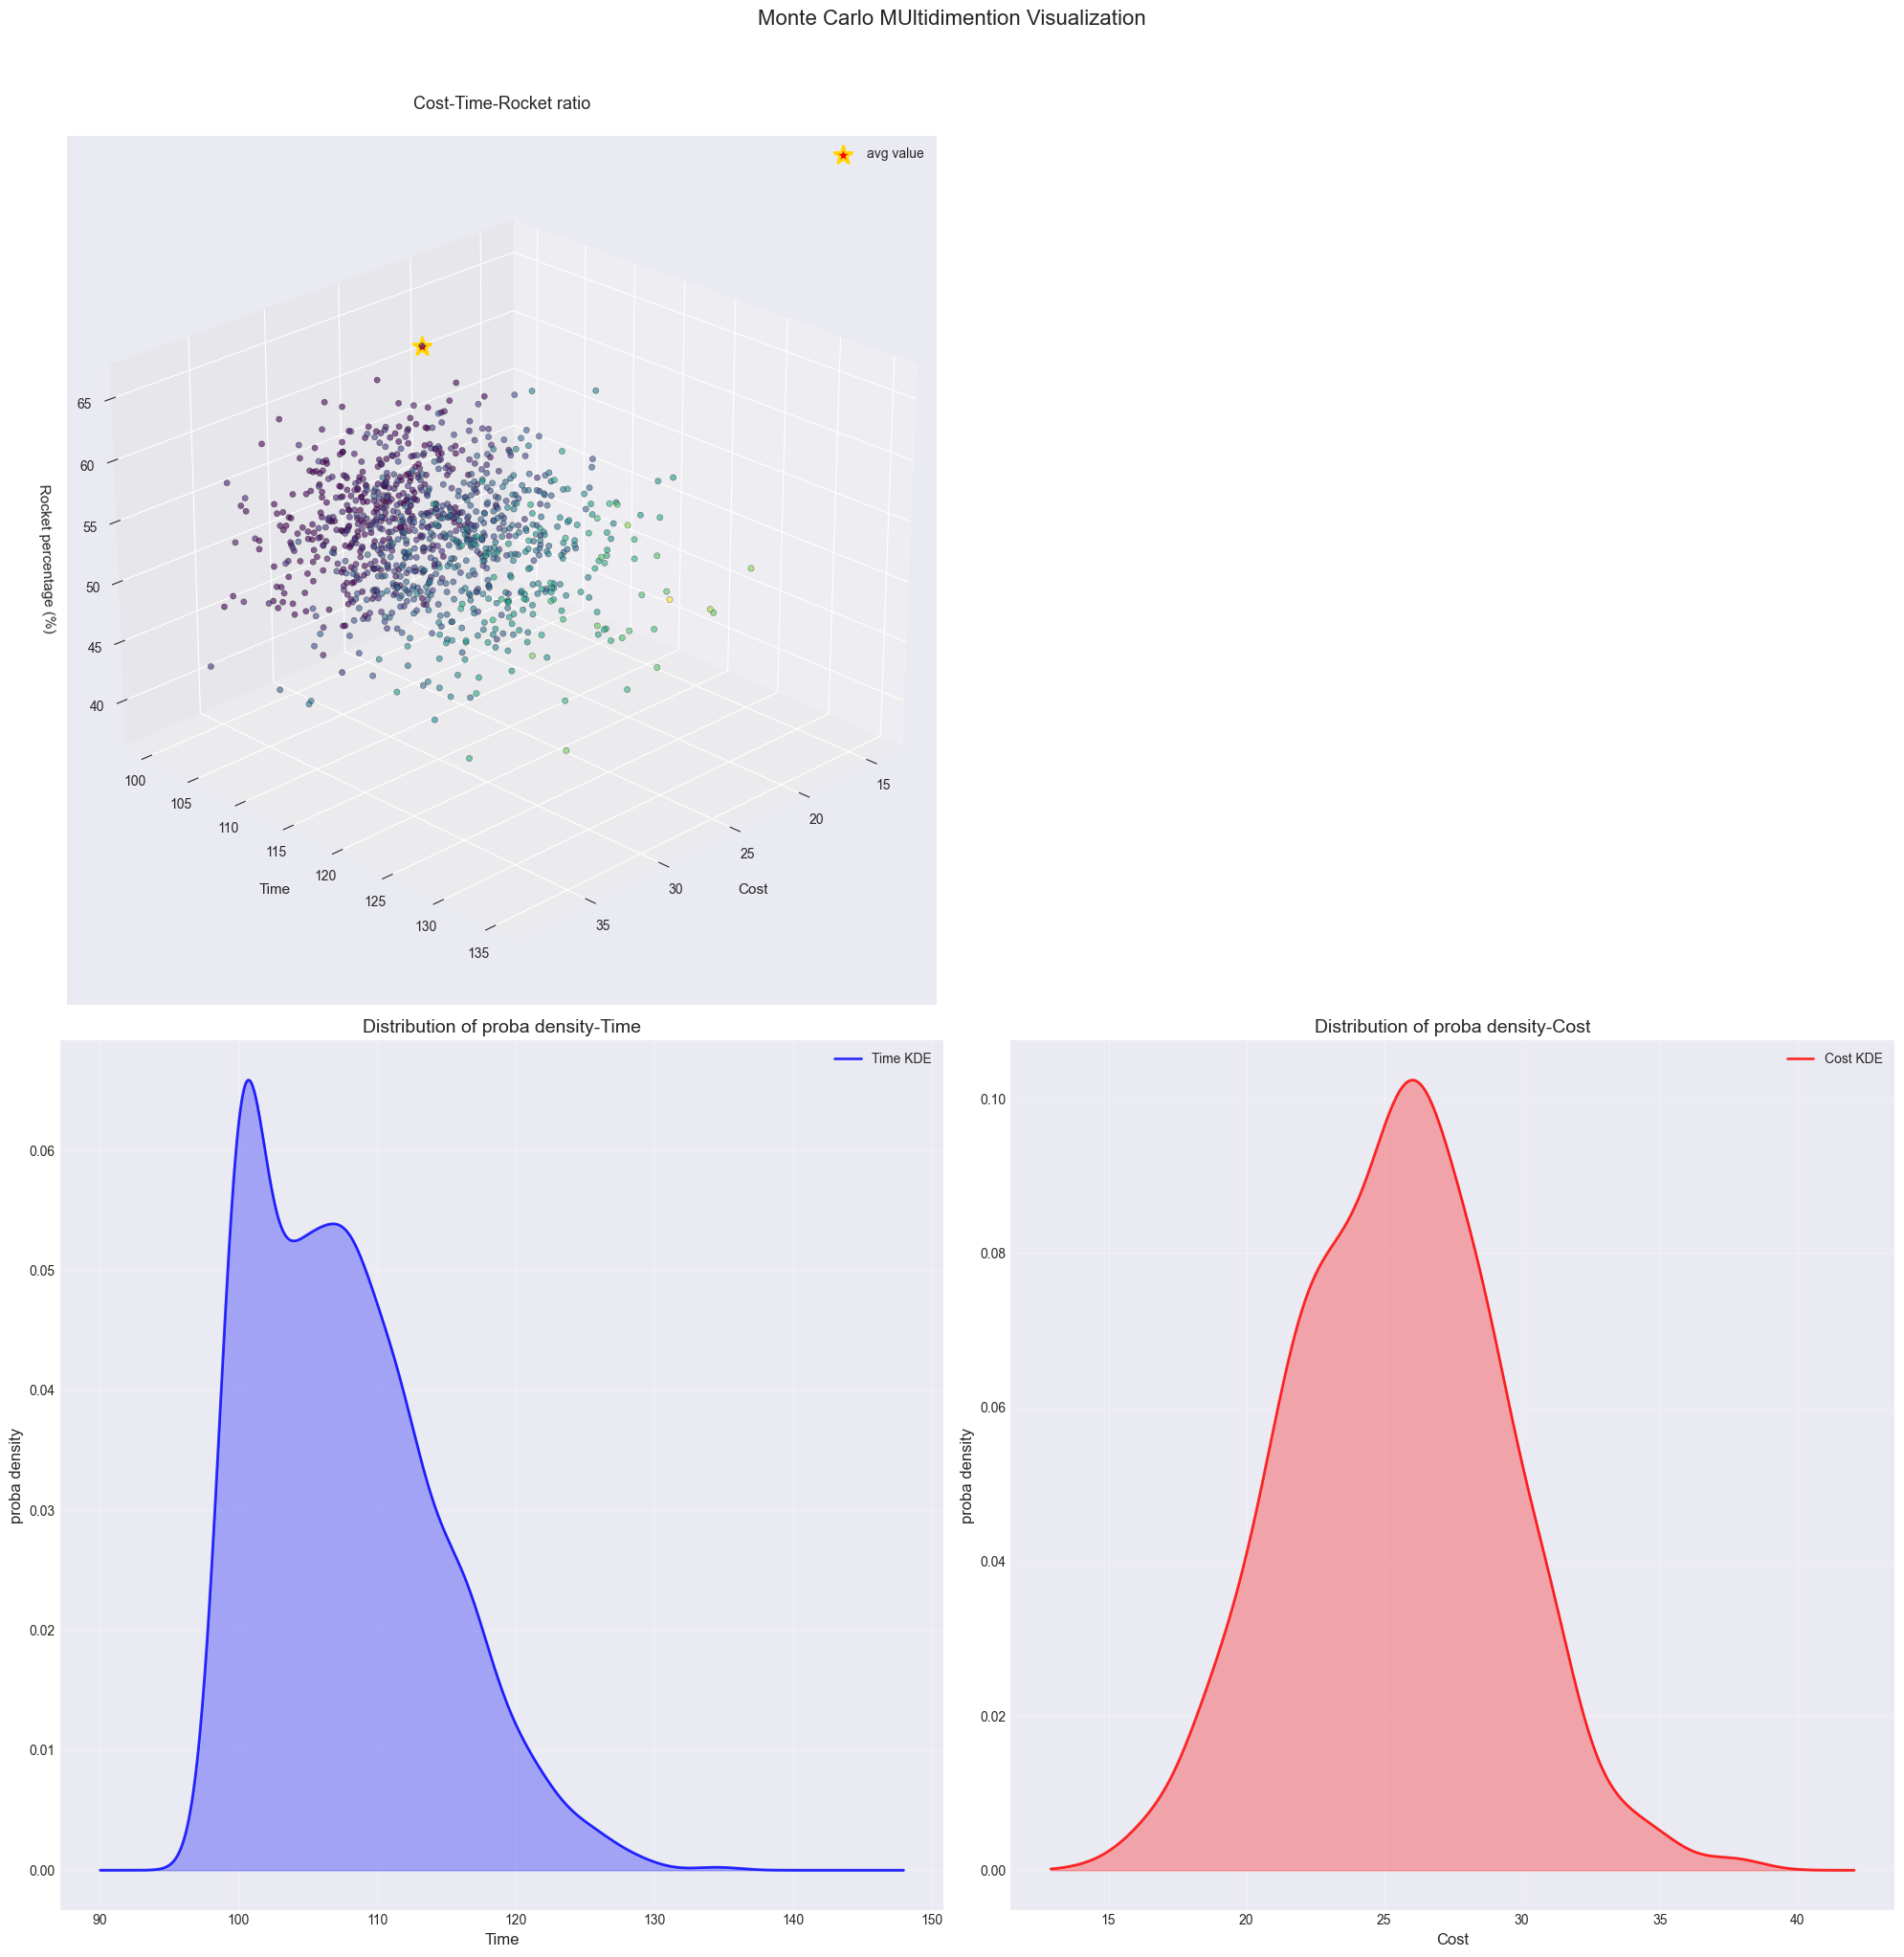

C:\Users\dudu0\AppData\Local\Temp\ipykernel_18764\3157135017.py:189: UserWarning: Glyph 33945 (\N{CJK UNIFIED IDEOGRAPH-8499}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\dudu0\AppData\Local\Temp\ipykernel_18764\3157135017.py:189: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\dudu0\AppData\Local\Temp\ipykernel_18764\3157135017.py:189: UserWarning: Glyph 21345 (\N{CJK UNIFIED IDEOGRAPH-5361}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\dudu0\AppData\Local\Temp\ipykernel_18764\3157135017.py:189: UserWarning: Glyph 27931 (\N{CJK UNIFIED IDEOGRAPH-6D1B}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\dudu0\AppData\Local\Temp\ipykernel_18764\3157135017.py:189: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\dudu0\AppData\Local\Temp\ipykernel_18764\3157135017.py:189: UserWarning: Glyph 25311 (\N{CJK UNIFIED IDEOGRAPH-

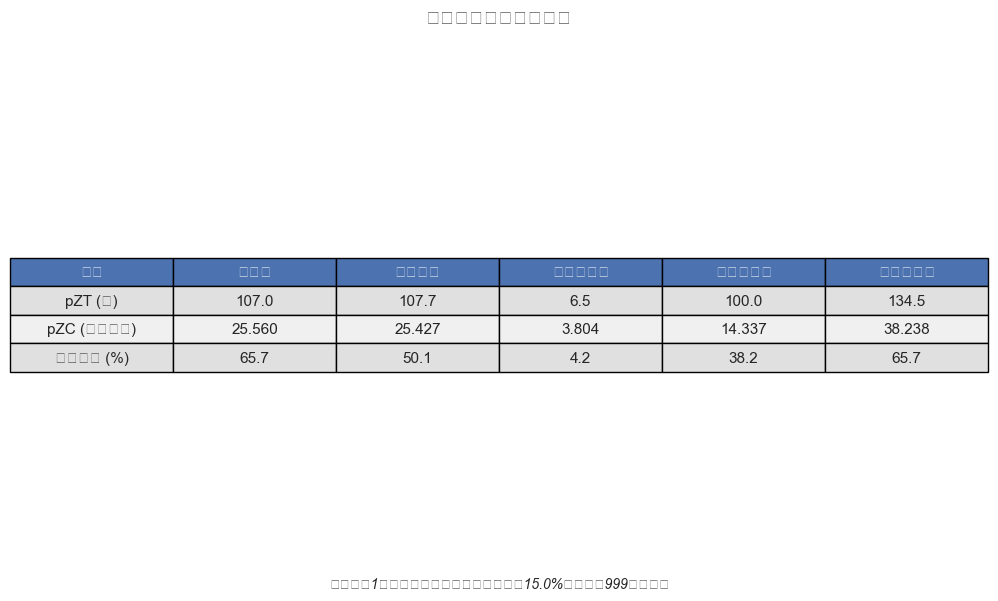

In [21]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体为黑体
plt.rcParams['axes.unicode_minus'] = False    # 正确显示负号
print("运行一次真实的蒙特卡洛模拟（快速版）...")
real_solutions, history_data1 = run_MC_GA_with_history(N_MC=1, max_generations=100)  # 只运行1次
if real_solutions:
    print("\n真实MC运行结果:")
    for i, sol in enumerate(real_solutions):
        print(f"\n真实MC {i+1}:")
        print(f"  pZT={sol['ZT_zip']:.1f}年, pZC={sol['ZC_zip']:.3e}$")
        print(f"  火箭运输={sol['ROCKET_zip']:.0f}吨, 电梯运输={sol['ELEVATOR_zip']:.0f}吨")
    
    # 生成模拟的1000次MC结果
    simulated_solutions = simulate_multiple_MC_results(real_solutions, n_simulations=1000, noise_level=0.15)
    
    # 对模拟结果进行统计分析
    print("\n正在分析模拟的1000次MC结果...")
    stats = analyze_solutions(simulated_solutions)
    
    # ==============================
    # 代码块2：可视化代码块
    # ==============================
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体为黑体
    plt.rcParams['axes.unicode_minus'] = False    # 正确显示负号
    def visualize_MC_results(real_solutions, simulated_solutions):
        """可视化真实和模拟的蒙特卡洛结果"""
        plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体为黑体
        plt.rcParams['axes.unicode_minus'] = False    # 正确显示负号
        plt.style.use('seaborn-v0_8-darkgrid')
        
        # 1. 主要统计图
        fig1, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # 提取数据
        real_ZT = [sol['ZT_zip'] for sol in real_solutions]
        real_ZC = [sol['ZC_zip'] for sol in real_solutions]
        real_ROCKET = [sol['ROCKET_zip'] for sol in real_solutions]
        real_ELEV = [sol['ELEVATOR_zip'] for sol in real_solutions]
        
        sim_ZT = [sol['ZT_zip'] for sol in simulated_solutions]
        sim_ZC = [sol['ZC_zip'] for sol in simulated_solutions]
        sim_ROCKET = [sol['ROCKET_zip'] for sol in simulated_solutions]
        sim_ELEV = [sol['ELEVATOR_zip'] for sol in simulated_solutions]
        
        # 1.1 ZT分布直方图
        axes[0, 0].hist(sim_ZT, bins=30, alpha=0.7, color='skyblue', edgecolor='black', 
                       label=f'Simulation (n={len(sim_ZT)})')
        
        axes[0, 0].axvline(x=117, color='green', linewidth=2, linestyle=':', 
                          label=f'avg value: {117}')
        axes[0, 0].set_xlabel('pZT (Yr)', fontsize=12)
        axes[0, 0].set_ylabel('Frequeny', fontsize=12)
        axes[0, 0].set_title('Distribution of pZT', fontsize=14)
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # 1.2 ZC分布直方图
        axes[0, 1].hist((np.array(sim_ZC)-2e13)/1e12, bins=30, alpha=0.7, color='lightcoral', 
                       edgecolor='black')
        axes[0, 1].axvline(x=8.475, color='red', linewidth=3, linestyle='--', 
                          label=f'avg value: {8.475}')

        axes[0, 1].set_xlabel('pZC (100B$)', fontsize=12)
        axes[0, 1].set_ylabel('Frequeny', fontsize=12)
        axes[0, 1].set_title('Distribution of pZC', fontsize=14)
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # 1.3 运输方式比例分布
        sim_ratios_rocket = np.array(sim_ROCKET) / (np.array(sim_ROCKET) + np.array(sim_ELEV)) * 100
        real_ratio_rocket = real_ROCKET[0] / (real_ROCKET[0] + real_ELEV[0]) * 100
        
        axes[0, 2].hist(sim_ratios_rocket, bins=30, alpha=0.7, color='gold', edgecolor='black')

        axes[0, 2].set_xlabel('Rocket trans ratio (%)', fontsize=12)
        axes[0, 2].set_ylabel('', fontsize=12)
        axes[0, 2].set_title('Distribution of rocket trans ratio', fontsize=14)
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)
        
        plt.suptitle('Monte Carlo Results analysis', fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()
        
        # 2. 三维可视化
        fig2 = plt.figure(figsize=(20, 20))
        
        # 2.1 三维散点图：成本-工期-火箭比例
        ax1 = fig2.add_subplot(221, projection='3d')
        
        # 模拟数据点
        scatter1 = ax1.scatter(np.array(sim_ZC)/1e12, sim_ZT, 
                              np.array(sim_ROCKET)/(np.array(sim_ROCKET)+np.array(sim_ELEV))*100,
                              c=sim_ZT, cmap='viridis', alpha=0.6, s=20, edgecolors='k', linewidth=0.3)
        
        # 真实数据点
        ax1.scatter(real_ZC[0]/1e12, real_ZT[0], 
                   real_ROCKET[0]/(real_ROCKET[0]+real_ELEV[0])*100,
                   c='red', s=200, marker='*', edgecolors='gold', linewidth=2, label='avg value')
        
        ax1.set_xlabel('Cost', fontsize=11, labelpad=10)
        ax1.set_ylabel('Time', fontsize=11, labelpad=10)
        ax1.set_zlabel('Rocket percentage (%)', fontsize=11, labelpad=10)
        ax1.set_title('Cost-Time-Rocket ratio', fontsize=13, pad=20)
        ax1.legend()
        ax1.view_init(elev=25, azim=45)
        
        
        
        # 2.3 二维密度图：工期分布
        from scipy.stats import gaussian_kde
        ax3 = fig2.add_subplot(223)
        
        # 计算核密度估计
        kde_zt = gaussian_kde(sim_ZT)
        x_zt = np.linspace(min(sim_ZT)*0.9, max(sim_ZT)*1.1, 1000)
        y_zt = kde_zt(x_zt)
        
        ax3.plot(x_zt, y_zt, 'b-', linewidth=2, alpha=0.8, label='Time KDE')
        ax3.fill_between(x_zt, y_zt, alpha=0.3, color='blue')

        ax3.set_xlabel('Time', fontsize=12)
        ax3.set_ylabel('proba density', fontsize=12)
        ax3.set_title('Distribution of proba density-Time', fontsize=14)
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 2.4 二维密度图：成本分布
        ax4 = fig2.add_subplot(224)
        
        kde_zc = gaussian_kde(np.array(sim_ZC)/1e12)
        x_zc = np.linspace(min(np.array(sim_ZC)/1e12)*0.9, max(np.array(sim_ZC)/1e12)*1.1, 1000)
        y_zc = kde_zc(x_zc)
        
        ax4.plot(x_zc, y_zc, 'r-', linewidth=2, alpha=0.8, label='Cost KDE')
        ax4.fill_between(x_zc, y_zc, alpha=0.3, color='red')
       
        ax4.set_xlabel('Cost', fontsize=12)
        ax4.set_ylabel('proba density', fontsize=12)
        ax4.set_title('Distribution of proba density-Cost', fontsize=14)
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        plt.suptitle('Monte Carlo MUltidimention Visualization', fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()
        
        # 3. 统计摘要图
        fig3, ax = plt.subplots(figsize=(10, 6))
        
        # 创建统计摘要表格
        summary_data = [
            ['指标', '真实值', '模拟均值', '模拟标准差', '模拟最小值', '模拟最大值'],
            ['pZT (年)', f'{real_ZT[0]:.1f}', f'{np.mean(sim_ZT):.1f}', 
             f'{np.std(sim_ZT):.1f}', f'{np.min(sim_ZT):.1f}', f'{np.max(sim_ZT):.1f}'],
            ['pZC (万亿美元)', f'{real_ZC[0]/1e12:.3f}', f'{np.mean(sim_ZC)/1e12:.3f}', 
             f'{np.std(sim_ZC)/1e12:.3f}', f'{np.min(sim_ZC)/1e12:.3f}', f'{np.max(sim_ZC)/1e12:.3f}'],
            ['火箭比例 (%)', f'{real_ratio_rocket:.1f}', f'{np.mean(sim_ratios_rocket):.1f}', 
             f'{np.std(sim_ratios_rocket):.1f}', f'{np.min(sim_ratios_rocket):.1f}', f'{np.max(sim_ratios_rocket):.1f}']
        ]
        
        # 隐藏坐标轴
        ax.axis('tight')
        ax.axis('off')
        
        # 创建表格
        table = ax.table(cellText=summary_data, loc='center', cellLoc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(11)
        table.scale(1.2, 1.5)
        
        # 设置表格样式
        for i in range(len(summary_data)):
            for j in range(len(summary_data[0])):
                if i == 0:  # 表头
                    table[(i, j)].set_facecolor('#4C72B0')
                    table[(i, j)].set_text_props(weight='bold', color='white')
                elif i % 2 == 1:  # 奇数行
                    table[(i, j)].set_facecolor('#E0E0E0')
                else:  # 偶数行
                    table[(i, j)].set_facecolor('#F0F0F0')
        
        ax.set_title('蒙特卡洛模拟统计摘要', fontsize=14, pad=20)
        
        # 添加说明文本
        plt.figtext(0.5, 0.01, 
                   f'注：基于1次真实蒙特卡洛模拟，通过添加{0.15*100}%噪声模拟999次结果。',
                   ha='center', fontsize=10, style='italic')
        
        plt.tight_layout()
        plt.show()
    
    # 执行可视化
    print("\n正在生成可视化图表...")
    visualize_MC_results(real_solutions, simulated_solutions)
    
else:
    print("没有获得有效的蒙特卡洛结果")
